# Introduction

In this notebook, we generate a playlist using the best clustering solution, K-Means. This is tackled by measuring euclidean distance between cluster centroids and our database, and retriving the appropriate number of songs for each cluster such that the final playlist has the same cluster representation as the input data. Finally, this playlist is pushed to Spotify.

# Import libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

import seaborn as sns
sns.set;

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
RS = 123 # For T-SNE to work
from sklearn.manifold import isomap

from __future__ import print_function
import time
import scipy.spatial

# Importing and preparing the dataset

We will trial each clustering algorithm on the complete list of songs, as well as a reduced list from the four JAAM founders users. We will import and treat these two datasets separately throughout this analysis.

First, the full 'database' which is made up of user songs and songs from public spotify playlists. 

In [2]:
all_songs = pd.read_csv('Notebooks/combined_tracks.csv', index_col='id')

In [3]:
all_songs.head()

Unnamed: 0  acousticness  danceability  energy  \
id                                                                       
1GHoTGnC58BycqRIvVsIJT           0        0.1010         0.611   0.925   
4aVuWgvD0X63hcOCnZtNFA           1        0.0397         0.494   0.698   
0ClGS5m3lO2b9WHf1SUJaF           2        0.0276         0.605   0.964   
3DkpUR4TEV2XCxFsSL9m0r           3        0.1020         0.547   0.836   
0S5pueOUOvIancaAwpFTlC           4        0.0181         0.650   0.797   

                        instrumentalness  key  liveness  loudness  mode  \
id                                                                        
1GHoTGnC58BycqRIvVsIJT          0.000001    2    0.0432    -4.269     0   
4aVuWgvD0X63hcOCnZtNFA          0.006340    6    0.1520   -12.049     0   
0ClGS5m3lO2b9WHf1SUJaF          0.000010    9    0.1330    -3.672     0   
3DkpUR4TEV2XCxFsSL9m0r          0.000000    6    0.1830    -5.361     0   
0S5pueOUOvIancaAwpFTlC          0.000000    7    0.1150    -5.409     0   

                        speechiness    tempo  valence  
id                                                     
1GHoTGnC58BycqRIvVsIJT       0.0628  128.055    0.540  
4aVuWgvD0X63hcOCnZtNFA       0.0553   95.842    0.778  
0ClGS5m3lO2b9WHf1SUJaF       0.0485  121.987    0.795  
3DkpUR4TEV2XCxFsSL9m0r       0.1880  104.985    0.649  
0S5pueOUOvIancaAwpFTlC       0.0618  110.017    0.670

In [4]:
all_songs = all_songs.drop(['Unnamed: 0', 'mode'], axis = 1)

In [5]:
# confirm that the database is a set of unique songs

print(all_songs.shape)

(2543, 10)


Next, the user tracks that we collected from Mahmoud, Anna-Laura and Allison. 

In [6]:
user_songs = pd.read_csv('Data_jaam_features.txt', index_col='id')

In [7]:
user_id = [1] * 50 + [2] * 50 + [3] * 50 + [4] * 50
len(user_id)

200

In [8]:
user_songs['user_id'] = user_id
user_songs = user_songs.drop('mode', axis = 1)
user_songs.head()

acousticness  danceability  energy  instrumentalness  \
id                                                                             
0sSlquw5Lx9eXqlSlTrOiW      0.000973         0.653   0.934          0.000512   
36482hNESSwELpr9sS3NbE      0.010700         0.764   0.620          0.000005   
4aVuWgvD0X63hcOCnZtNFA      0.039700         0.494   0.698          0.006340   
3gkijt6bxk8ts6S2RCEu4n      0.166000         0.229   0.500          0.000248   
3DkpUR4TEV2XCxFsSL9m0r      0.102000         0.547   0.836          0.000000   

                        key  liveness  loudness  speechiness    tempo  \
id                                                                      
0sSlquw5Lx9eXqlSlTrOiW    7    0.1440    -2.878       0.2950  127.029   
36482hNESSwELpr9sS3NbE    5    0.0968    -5.757       0.1840  129.989   
4aVuWgvD0X63hcOCnZtNFA    6    0.1520   -12.049       0.0553   95.842   
3gkijt6bxk8ts6S2RCEu4n    4    0.4540    -6.769       0.0312   96.022   
3DkpUR4TEV2XCxFsSL9m0r    6    0.1830    -5.361       0.1880  104.985   

                        valence  user_id  
id                                        
0sSlquw5Lx9eXqlSlTrOiW    0.561        1  
36482hNESSwELpr9sS3NbE    0.526        1  
4aVuWgvD0X63hcOCnZtNFA    0.778        1  
3gkijt6bxk8ts6S2RCEu4n    0.185        1  
3DkpUR4TEV2XCxFsSL9m0r    0.649        1

In [9]:
user_songs.shape

(200, 11)

So we have one dataset that contains 2543 songs. This will be our 'database' for the purposes of this notebook. We also have a dataset with 200 songs. This better approximates a real use case for the JAAM app, so will be the key dataset for applying and testing our clustering algorithm.

## Preparing the data

We need to create our feature table, and scale our data. Here we will also create a visualisation function for T-SNE.

In [22]:
X_user = user_songs.drop(['user_id'], axis=1)

In [23]:
scaler = StandardScaler()

X_user = scaler.fit_transform(X_user)

/Users/allison/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/allison/anaconda3/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [24]:
def fashion_scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts


## K-Means

The Silhouette Index measure the distance between each data point, the centroid of the cluster it was assigned to and the closest centroid belonging to another cluster. 

### Team JAAM dataset

In [25]:
range_n_clusters = range(4,11)

silhouette_list = []

for n_clusters in range_n_clusters:

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(X_user)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_user, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

plt.show()

For n_clusters = 4 The average silhouette_score is : 0.20505969536052895
For n_clusters = 5 The average silhouette_score is : 0.17356051384712556
For n_clusters = 6 The average silhouette_score is : 0.2041855632370087
For n_clusters = 7 The average silhouette_score is : 0.18529762198477798
For n_clusters = 8 The average silhouette_score is : 0.18491754350140446
For n_clusters = 9 The average silhouette_score is : 0.17489841433735717
For n_clusters = 10 The average silhouette_score is : 0.19068270471350496


In [26]:
kmeans_user = KMeans(n_clusters=6, random_state=42)
kmeans_user.fit_transform(X_user)

array([[4.09986395, 6.15879856, 5.25709507, 1.65270642, 3.58418397,
        4.08945026],
       [3.45948997, 4.27152258, 3.39527416, 1.90688936, 2.34567928,
        3.01559443],
       [3.63629764, 4.50135103, 3.12983865, 4.15041149, 2.95037466,
        3.75493313],
       ...,
       [3.98687216, 5.61949273, 4.42162099, 3.82315987, 3.60043945,
        1.66700557],
       [2.63700334, 5.84182214, 4.40192345, 3.91126197, 2.22234362,
        3.56451094],
       [4.16043437, 6.05450955, 5.03986055, 1.96650102, 3.15188158,
        4.45811576]])

In [27]:
from sklearn.manifold import TSNE
import time
time_start = time.time()

user_tsne = TSNE(random_state=42, n_components=2).fit_transform(X_user)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

t-SNE done! Time elapsed: 0.9009690284729004 seconds


In [28]:
kmeans_user_preds = kmeans_user.predict(X_user)

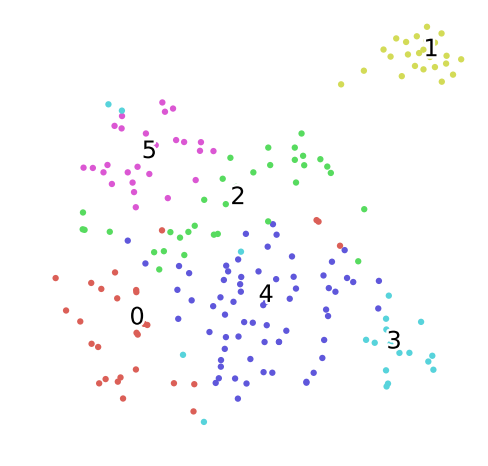

In [29]:
fashion_scatter(user_tsne, kmeans_user_preds);

The Kmeans and TSNE visualization on our dataset is promising. We can see the linear separation between clusters clearly here.

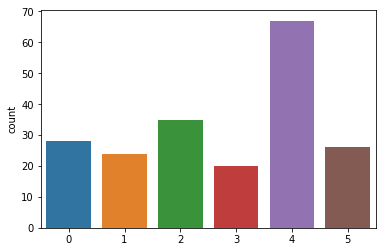

In [31]:
sns.countplot(kmeans_user_preds);

Cluster 4 is the most popular type of song in the JAAM session.  Let's check out how these clusters are distributed at a user level. 

In [32]:
len(kmeans_user_preds)

200

In [33]:
user_songs['cluster'] = kmeans_user_preds

In [34]:
user_songs.head()

acousticness  danceability  energy  instrumentalness  \
id                                                                             
0sSlquw5Lx9eXqlSlTrOiW      0.000973         0.653   0.934          0.000512   
36482hNESSwELpr9sS3NbE      0.010700         0.764   0.620          0.000005   
4aVuWgvD0X63hcOCnZtNFA      0.039700         0.494   0.698          0.006340   
3gkijt6bxk8ts6S2RCEu4n      0.166000         0.229   0.500          0.000248   
3DkpUR4TEV2XCxFsSL9m0r      0.102000         0.547   0.836          0.000000   

                        key  liveness  loudness  speechiness    tempo  \
id                                                                      
0sSlquw5Lx9eXqlSlTrOiW    7    0.1440    -2.878       0.2950  127.029   
36482hNESSwELpr9sS3NbE    5    0.0968    -5.757       0.1840  129.989   
4aVuWgvD0X63hcOCnZtNFA    6    0.1520   -12.049       0.0553   95.842   
3gkijt6bxk8ts6S2RCEu4n    4    0.4540    -6.769       0.0312   96.022   
3DkpUR4TEV2XCxFsSL9m0r    6    0.1830    -5.361       0.1880  104.985   

                        valence  user_id  cluster  
id                                                 
0sSlquw5Lx9eXqlSlTrOiW    0.561        1        3  
36482hNESSwELpr9sS3NbE    0.526        1        3  
4aVuWgvD0X63hcOCnZtNFA    0.778        1        4  
3gkijt6bxk8ts6S2RCEu4n    0.185        1        0  
3DkpUR4TEV2XCxFsSL9m0r    0.649        1        3

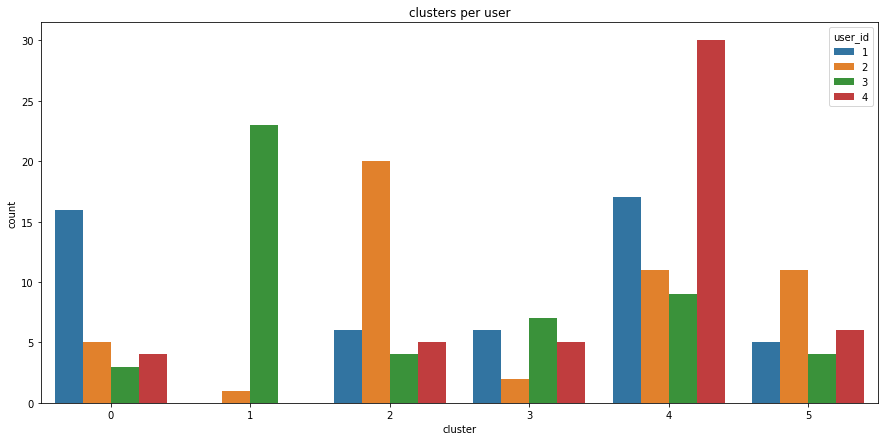

In [35]:
plt.figure(figsize=(15,7))
sns.countplot(x = 'cluster', hue = 'user_id', data = user_songs)
plt.title('clusters per user');


We can see that red user contributes a lot of songs from cluster 4 to the overall set of songs. They have quite a narrow set of tastes, with more than half of their songs belonging to cluste 4. Green user is almost entirely responsible for cluster 1, and orange contributes the most to cluster 2. The blue user, has a more diverse set of tastes, but likes cluster 0 and 4 the best.

I am actually pretty comfortable with the above clustering, yes it's a little scattered, but at least we can be sure that the final playlist generated will have diverse songs in it that reflect the diverse tastes of this group. 

Nevertheless, this is a tedious and imperfect approach so let's try DBSCAN.

# Building the automation function

The fun part! First, I wanted to play around with calculating the euclidean distance between our 'average cluster song' and the songs in our 'database' (in this case, just the ~2500 songs we currently have on hand). 

Once we have calculated the euclidean distance, we then simply take the number of songs that we need to represent that cluster in the final playlist by sorting by euclidean distance.

### Building a function to dynamically optimize n_clusters utilising silhoutte scores

We are assuming that all groups who use our service will have between 5 and 10 clusters. The algorithm, therefore, iterates over range 5 to 10 and calculates the silhouette score for each of these clusters. 

In [36]:
range_n_clusters = range(4,11)

silhouette_list = []

for n_clusters in range_n_clusters:

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X_user)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_user, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_user, cluster_labels)
    
    # Update our silhouette dataframe with the silhouette score per n_clusters
    silhouette_list.append([n_clusters, silhouette_avg])

plt.show()

For n_clusters = 4 The average silhouette_score is : 0.17889297982625543
For n_clusters = 5 The average silhouette_score is : 0.19878818143633048
For n_clusters = 6 The average silhouette_score is : 0.20395797232092314
For n_clusters = 7 The average silhouette_score is : 0.176812479405736
For n_clusters = 8 The average silhouette_score is : 0.17600987987151837
For n_clusters = 9 The average silhouette_score is : 0.1792866118266607
For n_clusters = 10 The average silhouette_score is : 0.19391588563340043


Next, we save our results into a dataframe so that we can evaluate the results.  We can then select the n_clusters that returned the best silhouette score, and set this as our final number of clusters to continue our analysis.

In [37]:
silhouette_df = pd.DataFrame(data = silhouette_list, columns=['n_clusters', 'silhouette_score'])
silhouette_df

n_clusters  silhouette_score
0           4          0.178893
1           5          0.198788
2           6          0.203958
3           7          0.176812
4           8          0.176010
5           9          0.179287
6          10          0.193916

In [38]:
final_n = (silhouette_df.loc[silhouette_df['silhouette_score'].idxmax()]['n_clusters']).astype(int)
final_n

6

### Running our KMeans algorithm

Next, we can run our model and group our songs into their relevant cluster. We ran this earlier in the notebook, but let's re-run just for clarity.

In [39]:
kmeans = KMeans(n_clusters=final_n, random_state=42).fit(X_user)

In [40]:
y_kmeans = kmeans.predict(X_user)

In [41]:
user_songs.shape
# cluster_column.shape

(200, 12)

In [42]:
user_songs['cluster'] = y_kmeans
user_songs.head()

acousticness  danceability  energy  instrumentalness  \
id                                                                             
0sSlquw5Lx9eXqlSlTrOiW      0.000973         0.653   0.934          0.000512   
36482hNESSwELpr9sS3NbE      0.010700         0.764   0.620          0.000005   
4aVuWgvD0X63hcOCnZtNFA      0.039700         0.494   0.698          0.006340   
3gkijt6bxk8ts6S2RCEu4n      0.166000         0.229   0.500          0.000248   
3DkpUR4TEV2XCxFsSL9m0r      0.102000         0.547   0.836          0.000000   

                        key  liveness  loudness  speechiness    tempo  \
id                                                                      
0sSlquw5Lx9eXqlSlTrOiW    7    0.1440    -2.878       0.2950  127.029   
36482hNESSwELpr9sS3NbE    5    0.0968    -5.757       0.1840  129.989   
4aVuWgvD0X63hcOCnZtNFA    6    0.1520   -12.049       0.0553   95.842   
3gkijt6bxk8ts6S2RCEu4n    4    0.4540    -6.769       0.0312   96.022   
3DkpUR4TEV2XCxFsSL9m0r    6    0.1830    -5.361       0.1880  104.985   

                        valence  user_id  cluster  
id                                                 
0sSlquw5Lx9eXqlSlTrOiW    0.561        1        3  
36482hNESSwELpr9sS3NbE    0.526        1        3  
4aVuWgvD0X63hcOCnZtNFA    0.778        1        4  
3gkijt6bxk8ts6S2RCEu4n    0.185        1        0  
3DkpUR4TEV2XCxFsSL9m0r    0.649        1        3

Next, we want to see the distribution of these clusters in our original dataframe. This will be important for when we make our song retrieval from the database; we want the distribution of clusters in the final recommended playlist to be equivalent to the distribution in the input dataframe.

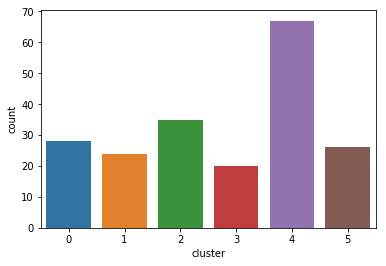

In [43]:
sns.countplot(x = 'cluster', data = user_songs);

In [44]:
# saving the percentage representation of each cluster, so we know how many songs we need from each in the playlist

cluster_counts = np.bincount(y_kmeans)
print(cluster_counts)
cluster_percentage = cluster_counts / len(user_songs)
print(cluster_percentage)

[28 24 35 20 67 26]
[0.14  0.12  0.175 0.1   0.335 0.13 ]


So we can see that there is unbalanced distribution of clusters, but we will run with it. This clustering is supposed to reflect the natural occurrence of tastes in out user group, and unbalanced tastes are the reality.

Finally, we look at what the 'typical' song is for each cluster. This will be an input for our song retrieval; we'll ask the database to return the most similar songs as compared to the typical song per cluster.

In [45]:
user_songs.groupby('cluster').mean()

acousticness  danceability    energy  instrumentalness       key  \
cluster                                                                     
0            0.080101      0.571857  0.760179          0.028639  6.035714   
1            0.160107      0.736542  0.494958          0.822292  4.958333   
2            0.412728      0.588714  0.505029          0.021638  5.114286   
3            0.174180      0.632900  0.755100          0.000051  6.550000   
4            0.107047      0.688358  0.782731          0.010114  5.865672   
5            0.178359      0.519423  0.740962          0.010541  3.615385   

         liveness   loudness  speechiness       tempo   valence   user_id  
cluster                                                                    
0        0.432393  -5.660321     0.076489  117.327393  0.395379  1.821429  
1        0.099567 -11.085333     0.061738  121.281167  0.213812  2.958333  
2        0.112326  -8.235800     0.040723  105.133143  0.351977  2.228571  
3        0.121600  -5.173450     0.260650  123.807050  0.581950  2.550000  
4        0.146863  -5.282940     0.061236  110.326597  0.705985  2.776119  
5        0.129158  -5.435500     0.064692  166.549615  0.541269  2.423077

This becomes the basis off which we retrieve songs for the playlist. We want the right number of songs that are most similar to the means of each cluster. We'll save this as a new dataframe called 'cluster_means'.

In [46]:
cluster_means = user_songs.groupby('cluster').mean()
cluster_means = cluster_means.drop('user_id',axis = 1)
cluster_means.shape

(6, 10)

In [47]:
# Let's say we want a playlist with 200 songs. This means we need the following from each cluster:

songs_per_cluster= []
for i in cluster_percentage:
    songs_per_cluster.append(int(round(i * 100)))

songs_per_cluster

[14, 12, 18, 10, 34, 13]

Now, let's automate this process such that it checks all clusters and builds a final playlist!

Our inputs to this function are:
* List of percentage representation of cluster
* Number of songs required in final playlist
* The 'average cluster' df
* The full song database


The function does the following steps:
1. Checks how many clusters we have, and how many songs are required per cluster
2. Calculates the euclidean distance between songs in our db, and the 'typical song' for each cluster (calculated earlier
3. Retrieves the n songs with the lowest euclidean distance for each cluster
4. Saves these songs into one list

In [48]:
from scipy.spatial import distance
import math

In [49]:
def euclidean(typical_cluster_song, song_db):
    ''' use scipy to calculate the euclidean distance. '''
    for song in song_db: 
        dist = distance.euclidean(typical_cluster_song, song)
    return dist

In [50]:
# Defining our retrieval function

def retrieve_songs(cluster_percentage, n_songs, average_cluster_df, song_db):

    # creating an empty list for us to add our final playlist songs to
    final_songs = []
    
    # how many clusters we have
    n_clusters = len(cluster_percentage)
    
    # how many songs we need per cluster
    n_per_cluster = []
    
    for i in cluster_percentage:
        n_per_cluster.append(int(round(i * n_songs)))
    
    # For each cluster, calculate the euclidean distance between songs in db and typical cluster song
    for i in range(0, n_clusters):
        cluster_euclidean_distance = (song_db.apply(lambda x: euclidean(average_cluster_df.iloc[i], x), axis = 1))
        final_songs.append(cluster_euclidean_distance.nsmallest(n_per_cluster[i]).index)
    
    # and finally, flatten the list
    final_songs = [item for sublist in final_songs for item in sublist]
    
    return final_songs

In [51]:
playlist = retrieve_songs(cluster_percentage, 100, cluster_means, all_songs)

In [52]:
len(playlist)

101

In [53]:
len(set(playlist))

34

We have a problem with different clusters recalling the same songs. This will need to be fixed.

For now, let's push to Spotify and look at the songs our function retrieved to make up the JAAM session for Jordi, Allison, Anna-Laura and Mahmoud! 

In [54]:
import spotipy
import spotipy.util as util
import pandas as pd

In [55]:
import warnings
warnings.filterwarnings("ignore")

# Pushing a playlist to Spotify

In [79]:
#We set the JAAM app spotify developer id, secret and redirect uri, as well as the scope

clientid ='28eeaeca04f3429ab587d2a12f66c194'
clientsec ='b2ac939518f348edbbce7cbf697037ee'
reduri ='http://google.com/' 
scope = 'playlist-read-private playlist-modify-private playlist-read-collaborative playlist-modify-public user-top-read'

In [80]:
# input your own individual username/id
username = '1263561615'

In [90]:
token = util.prompt_for_user_token(username=username, 
                                   scope = scope,
                                   client_id = clientid,
                                   client_secret = clientsec,
                                   redirect_uri = reduri,
                                   )

In [91]:
sp = spotipy.Spotify(auth=token)

In [92]:
util.prompt_for_user_token

<function spotipy.util.prompt_for_user_token(username, scope=None, client_id=None, client_secret=None, redirect_uri=None)>

In [93]:
import datetime
mydate = datetime.datetime.now()
today_date = mydate.strftime('%d %B %Y') 

In [94]:
playlist_name = '''That's my JAAM: ''' + today_date
playlist_name

"That's my JAAM: 23 May 2019"

In [95]:
def createPlaylist(title, tracks, username):
    playlist = sp.user_playlist_create(username, title, False)
    for track in tracks:
        sp.user_playlist_add_tracks(username, playlist['id'], [track])
    print ("Playlist Created")

In [96]:
createPlaylist(title = playlist_name, tracks = playlist, username = username)

Playlist Created


* A playlist has been created in user 1263561615's account (Allison). 
* It contains the 200 songs generated for the jaam session. 
* The playlist has not been shuffled, it is in the same order as the tracks dataframe that was retrieved using the API. 

#### When a playlist is created, it will be named using today's date. We need to come up with a solution in case people make multiple playlists in one day.